In [1]:
import sys
import os 


import bk.load
import bk.compute
import bk.plot

import basefunction.vBaseFunctions3 as vbf
import neuroseries as nts

import numpy as np
import pandas as pd
import scipy.signal

from scipy.signal import savgol_filter
from scipy.stats import zscore

from tqdm import tqdm




import matplotlib.pyplot as plt
import seaborn as sns 

# %matplotlib qt

%load_ext memory_profiler
import cProfile
import itertools
import time

In [2]:
import matplotlib as mpl

COLOR = "white"
# mpl.rcParams['text.color'] = COLOR
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['axes.edgecolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR
# mpl.rcParams['figure.facecolor'] = '#282C34'
# mpl.rcParams['axes.facecolor'] = '#282C34'
mpl.rcParams["svg.fonttype"] = "none"
mpl.rcParams["font.family"] = "Sawasdee"
# %matplotlib qt


In [3]:
def population_rates(neurons, binSize=0.010, start=0, end=None):
    t, binned = bk.compute.binSpikes(neurons, binSize, start, end)
    pop = binned.sum(0)
    return t, pop


def wavelet_spectrogram(lfp, fmin, fmax, nfreq):
    f_wv = pow(2, np.linspace(np.log2(fmin), np.log2(fmax), nfreq))
    t = lfp.index.values
    output = vbf.wvSpect(lfp.values, f_wv)

    return f_wv, t, output[0]



In [4]:
def plot_lfp(lfp, t_start, t_end, ax):
    ax.plot(lfp.as_units("s")[t_start:t_end])
    ax.set_ylim([-2500, 2500])
    ax.set_xlim([t_start, t_end])


def plot_spectrogram(t, f, Sxx, method, ax):
    if method == "wavelet":
        ax.pcolormesh(t, f, Sxx, shading="gouraud", vmin=0, vmax=350, rasterized=True)
    else:
        ax.pcolormesh(
            t, f, Sxx, shading="gouraud", vmin=0, vmax=20_000, rasterized=True
        )

    ax.set_ylim(0, 50)
    ax.set_xlim(t[0], t[-1])


def plot_raster(neurons, metadata, region, intervals, ax):
    t_start = intervals.as_units("s").start.values[0]
    t_end = intervals.as_units("s").end.values[0]
    for i, n in enumerate(
        neurons[(metadata.Region == region) & (metadata.Type == "Pyr")]
    ):
        t = n.restrict(intervals).as_units("s").index
        ax.plot(t, t - t + i, "k|")

    for i, n in enumerate(
        neurons[(metadata.Region == region) & (metadata.Type == "Int")],
        len(neurons[(metadata.Region == region) & (metadata.Type == "Pyr")]),
    ):
        t = n.restrict(intervals).as_units("s").index
        ax.plot(t, t - t + i, "r|")
    ax.set_xlim(t_start, t_end)


def plot_population_rates(t_pop, p, intervals, ax):
    t_start = intervals.as_units("s").start.values[0]
    t_end = intervals.as_units("s").end.values[0]

    ax.bar(t_pop, p, t_pop[1] - t_pop[0])
    ax.set_xlim(t_start, t_end)



In [5]:
def plot_data(lfp, neurons, metadata, region, window, method="wavelet"):

    t_start = window[0]
    t_end = window[1]

    intervals = nts.IntervalSet(t_start, t_end, time_units="s")

    t_pop, p = population_rates(
        neurons[(metadata.Region == region) & (metadata.Type == "Pyr")],
        0.025,
        t_start,
        t_end,
    )
    lfp_state = lfp.restrict(intervals)

    f, t, Sxx = scipy.signal.spectrogram(
        lfp_state.as_units("s")[t_start:t_end].values, 1250, nperseg=250, noverlap=125
    )
    if method == "wavelet":
        f, t, Sxx = wavelet_spectrogram(
            lfp_state.as_units("s")[t_start:t_end], 1.5, 300, 500
        )

    fig, ax = plt.subplot_mosaic(
        """A
                                   B
                                   B
                                   C
                                   C
                                   D
                                """,
        figsize=[12, 8],
    )

    plot_lfp(lfp_state, t_start, t_end, ax["A"])
    plot_spectrogram(t, f, Sxx, method, ax["B"])
    plot_raster(neurons, metadata, region, intervals, ax["C"])
    plot_population_rates(t_pop, p, intervals, ax["D"])

    ax["A"].sharex(ax["B"])
    ax["B"].sharex(ax["C"])

    plt.tight_layout()


Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


FileNotFoundError: [Errno 2] No such file or directory: '/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/SWS - BLA - 121 -18886s.svg'

/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


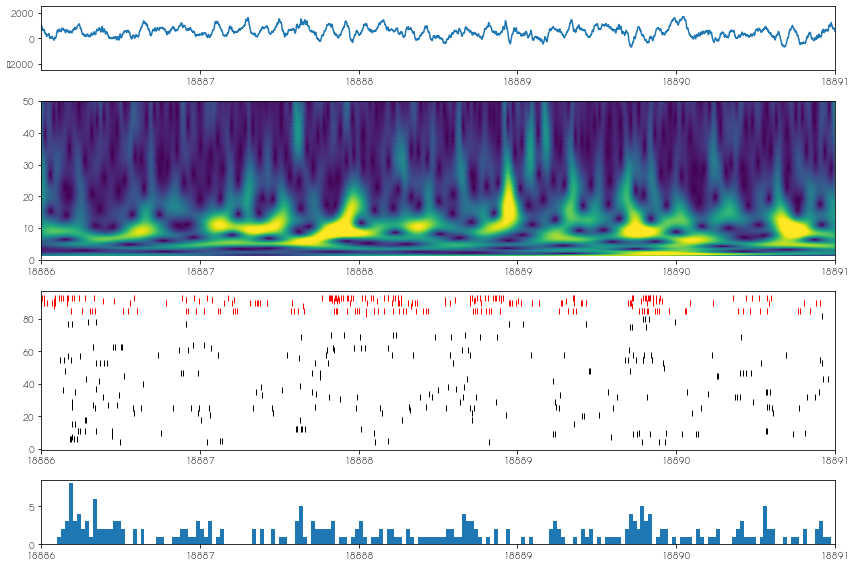

In [6]:
i = 18886

region = "BLA"

bk.load.current_session_linux()
states = bk.load.states()
chan = 121
lfp = bk.load.lfp(chan, 18_000, 20_000)
neurons, metadata = bk.load.loadSpikeData(bk.load.path)

plot_data(lfp, neurons, metadata, "BLA", [i, i + 5])
types = ["svg", "pdf", "eps"]
for t in types:
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/SWS - {region} - {chan} -{i}s.{t}",
        dpi=300,
    )

region = "Hpc"

bk.load.current_session_linux()
states = bk.load.states()
chan = 23
lfp = bk.load.lfp(chan, 18_000, 20_000)
neurons, metadata = bk.load.loadSpikeData(bk.load.path)
types = ["svg", "pdf", "eps"]
for t in types:
    plot_data(lfp, neurons, metadata, "Hpc", [i, i + 5])
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/SWS - {region} - {chan} -{i}s.{t}",
        dpi=300,
    )



Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_svg.py:1125: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_svg.py:1125: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:102: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/

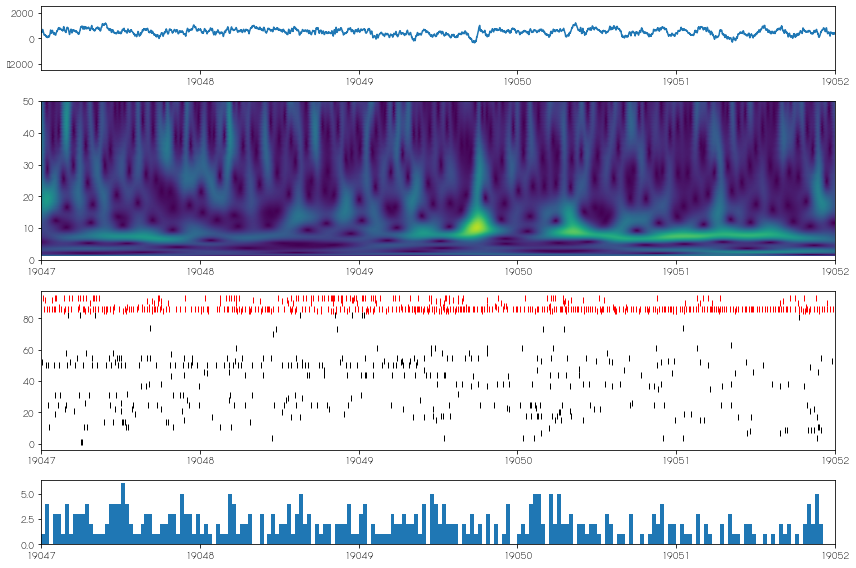

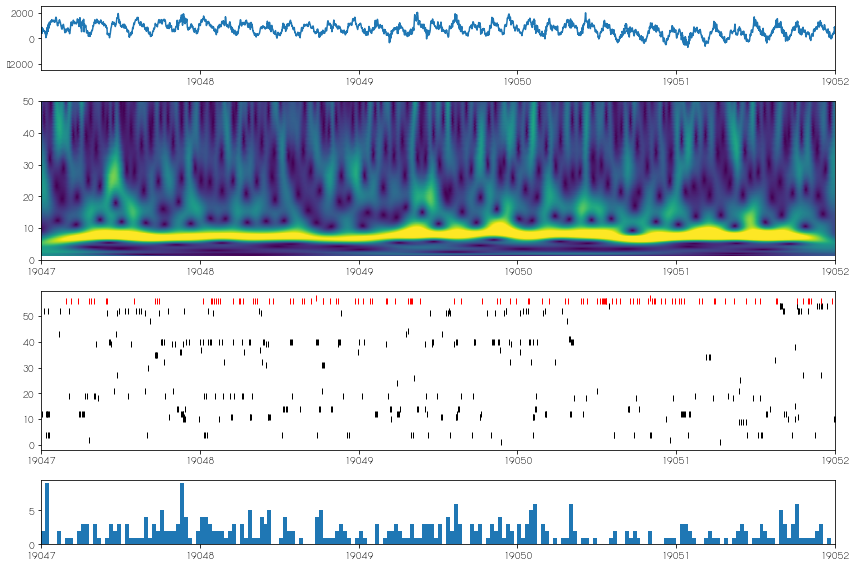

In [ ]:
i = 19047

region = "BLA"

bk.load.current_session_linux()
states = bk.load.states()
chan = 121
lfp = bk.load.lfp(chan, 19_000, 20_000)
neurons, metadata = bk.load.loadSpikeData(bk.load.path)

plot_data(lfp, neurons, metadata, "BLA", [19047, 19047 + 5])
types = ["svg", "pdf", "eps"]
for t in types:
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/REM - {region} - {chan} -{i}s.{t}",
        dpi=300,
    )

region = "Hpc"

bk.load.current_session_linux()
states = bk.load.states()
chan = 23
lfp = bk.load.lfp(chan, 19_000, 20_000)
neurons, metadata = bk.load.loadSpikeData(bk.load.path)

plot_data(lfp, neurons, metadata, "Hpc", [19047, 19047 + 5])
types = ["svg", "pdf", "eps"]
for t in types:
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/REM - {region} - {chan} -{i}s.{t}",
        dpi=300,
    )

In [ ]:
region = "BLA"

bk.load.current_session_linux()
states = bk.load.states()
chan = bk.load.random_channel("BLA")
chan = 125
lfp = bk.load.lfp(chan, 0, 25_000)
neurons, metadata = bk.load.loadSpikeData(bk.load.path)
ripples = bk.load.ripples()


rem = []
for i in states["Rem"].as_units("s").iloc:
    rem.append([np.random.randint(i.start, i.end - 10, 2)])

sws = []
for i in states["sws"].as_units("s").iloc:
    sws.append([np.random.randint(i.start, i.end - 10, 2)])

plt.ioff()
rem = np.array(rem).flatten()
sws = np.array(sws).flatten()

rem.sort()
sws.sort()
for i in np.array(rem).flatten():
    plot_data(lfp, neurons, metadata, region, [i, i + 5])
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/REM - {chan} -{i}s.png",
        dpi=300,
    )
    plt.close("all")

for i in np.array(sws).flatten():
    plot_data(lfp, neurons, metadata, region, [i, i + 5])
    plt.savefig(
        f"/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/Example/figs/SWS - {chan} - {i}s.png",
        dpi=300,
    )
    plt.close("all")



Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: Run

In [ ]:
for s, intervals in states.items():
    intervals = intervals.drop_short_intervals(5)

    t_start = intervals.as_units("s").iloc[0][0] + 35
    t_end = t_start + 5
    t_pop, p = population_rates(
        neurons[(metadata.Region == "BLA") & (metadata.Type == "Int")],
        0.025,
        t_start,
        t_end,
    )
    lfp_state = lfp.restrict(intervals)

    # f,t,Sxx = scipy.signal.spectrogram(lfp_state.as_units('s')[t_start:t_end].values,1250,nperseg=250,noverlap=125)
    f, t, Sxx = wavelet_spectrogram(lfp_state.as_units("s")[t_start:t_end], 1, 100, 300)
    fig, ax = plt.subplot_mosaic(
        """A
                                   B
                                   C
                                   C
                                   C
                                """,
        figsize=[12, 8],
    )
    ax["A"].plot(lfp_state.as_units("s")[t_start:t_end])
    ax["A"].set_ylim([-1000, 1000])
    ax["A"].set_xlim([t_start, t_end])

    plt.sca(ax["B"])
    plt.pcolormesh(t, f, Sxx, shading="auto")
    plt.xlim([t_start, t_end])
    plt.ylim([0, 100])
    plt.clim([0, 5000])

    plt.sca(ax["C"])
    bk.plot.rasterPlot(neurons[metadata.Region == "BLA"], [t_start, t_end], width=1)
    plt.bar(t_pop, p, t_pop[1] - t_pop[0])
    plt.xlim([t_start, t_end])

    plt.suptitle(s + " BLA Shank - 16 Channel - 123")
    plt.tight_layout()
#     plt.savefig(f'/mnt/work/Figures Gabrielle/{s}-BLA-S16C123.png',dpi = 300)


ERROR: input signal needs at least 6547 time points for 1.0Hz-wavelet convolution
ERROR: input signal needs at least 6448 time points for 1.0155211276345681Hz-wavelet convolution
ERROR: input signal needs at least 6350 time points for 1.0312831606721848Hz-wavelet convolution
ERROR: input signal needs at least 6253 time points for 1.0472898382363585Hz-wavelet convolution


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


ERROR: input signal needs at least 6547 time points for 1.0Hz-wavelet convolution
ERROR: input signal needs at least 6448 time points for 1.0155211276345681Hz-wavelet convolution
ERROR: input signal needs at least 6350 time points for 1.0312831606721848Hz-wavelet convolution
ERROR: input signal needs at least 6253 time points for 1.0472898382363585Hz-wavelet convolution


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


ERROR: input signal needs at least 6547 time points for 1.0Hz-wavelet convolution
ERROR: input signal needs at least 6448 time points for 1.0155211276345681Hz-wavelet convolution
ERROR: input signal needs at least 6350 time points for 1.0312831606721848Hz-wavelet convolution
ERROR: input signal needs at least 6253 time points for 1.0472898382363585Hz-wavelet convolution


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


ERROR: input signal needs at least 6547 time points for 1.0Hz-wavelet convolution
ERROR: input signal needs at least 6448 time points for 1.0155211276345681Hz-wavelet convolution
ERROR: input signal needs at least 6350 time points for 1.0312831606721848Hz-wavelet convolution
ERROR: input signal needs at least 6253 time points for 1.0472898382363585Hz-wavelet convolution


/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/billel/anaconda3/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)


Error in callback <function flush_figures at 0x7f69e2c71280> (for post_execute):


KeyboardInterrupt: 